# Measuring supernova magnitudes

let's start using the magic function we learned last time "%pylab inline"
<br> then we can import the packeages we will use today: sep, astropy  
<br> from astropy we will import: fits and wcs

In [1]:
%pylab inline
from astropy.io import fits
from astropy import wcs as wcs
import sep
import glob
from astropy.wcs import WCS

Populating the interactive namespace from numpy and matplotlib


# read an image
B-median.fits is our test image. we will use fits.open to open and put the image in a variable img
<br> let's see the image format. Fits mean "Flexible Image Transport System" 
<br> this is a specific format composed by a metadata part and a data part.
The metadata (header) include all the info about the image and the data part is usually a bidimensional array. A fits image can have multiple layers of metadata and data.
<br> For example:<br>
<br> header, data  (level[0])
<br> header, data  (level[1])
<br> header, data  (level[2])
<br> You can see how many layers your image has using the function len()

In [2]:
#img = fits.open('B-median.fits')
imglist=glob.glob('NGC*fits')
SN_RA = 177.757464 
SN_DEC = -28.743997
STD_RA = 177.7401436
STD_DEC = -28.7764212
std_mag = 15.585 #  16.048
#hdu = fits.open('NGC3923_2018-03-31.86.fits')

In [3]:
hdu= fits.open(imglist[0])
header = hdu[0].header
#print(header)

Now we would like to be able to find the position of all stars in the image. But in order to do that with the package sep, we need to define the background of the image. 
Sep has a command for that: sep.Background(X). 
But before doing that there is a command to run: X = X.byteswap().newbyteorder() then we can subtract the background

In [4]:
flux_vec =[]
flux_std_vec=[]
fluxerr_vec =[]
jd_vec = []
ZP_vec = []
for img in imglist:
    hdu= fits.open(img)
    header = hdu[0].header
    X = hdu[0].data
    X = X.byteswap().newbyteorder()
    bkg = sep.Background(X)
    data_sub = X - bkg
    # Now we can exstract all the objects from the image using the sep commmand 
    # sep.extract and then we can plot all the star detected on our image.  
    # thresh=3.0 define how many star we want to find larger numbers means 
    # we find less objects. This is similar to a dictionary with each column 
    # that can be identify by a name. 
    objects = sep.extract(data_sub, thresh=3.0, err=bkg.globalrms, mask=None, \
                          minarea=10, clean=True, filter_type = 'matched',\
                          clean_param=1.0, segmentation_map=False)
    #Finally, we’ll perform simple circular aperture photometry with 
    # a 3 pixel radius at the locations of the objects:
    flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     5.0, err=bkg.globalrms, gain=1.0)
    # take information from the header about the coordinate where 
    # the image is pointing to.
    w = WCS(header)
    #transform SN coordinate in pixels:
    px, py = w.wcs_world2pix(SN_RA,SN_DEC, 1)
    std_px, std_py = w.wcs_world2pix(STD_RA,STD_DEC, 1)
    #let's loop over the stars 
    # we will use for and "enumerate"
    # let's now make the difference between each pixel of an object and px py
    # let add an iff statment in the loop to select only the element we want 
    sn=False
    std=False
    for i,j in enumerate(objects['x']):
        if (objects['x'][i]-px)**2+(objects['y'][i]-py)**2 <15:
            sn=i
        if (objects['x'][i]-std_px)**2+(objects['y'][i]- std_py)**2 < 15:
            std=i
        if std is not False and sn is not False:
                flux_vec.append(flux[sn])
                flux_std_vec.append(flux[std])
                fluxerr_vec.append(fluxerr[sn])
                jd_vec.append(header['jd'])
                ZP_vec.append(header['ZP'])
                break
    if std is False or sn is False:
        print(img,' this image is missing the sn or the standard')
#        print(sn,std,std_px,std_py,px,py)
        

NGC3923_2018-04-04.51.fits  this image is missing the sn or the standard
NGC3923_2018-04-05.61.fits  this image is missing the sn or the standard
NGC3923_2018-04-29.06.fits  this image is missing the sn or the standard
NGC3923_2018-04-09.6.fits  this image is missing the sn or the standard
NGC3923_2018-04-02.52.fits  this image is missing the sn or the standard
NGC3923_2018-06-07.16.fits  this image is missing the sn or the standard
NGC3923_2018-04-09.56.fits  this image is missing the sn or the standard
NGC3923_2018-05-13.03.fits  this image is missing the sn or the standard
NGC3923_2018-05-03.25.fits  this image is missing the sn or the standard


the zero point of the first image image is  26.907889787712982
The peak magnitude is  12.988742743928931


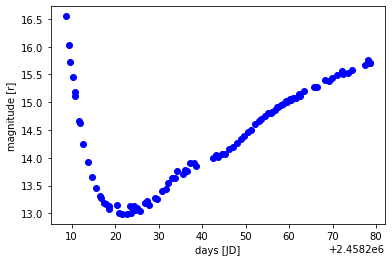

In [8]:
# transform the flux in magnitude for the SN and the std
mag_vec = -2.5 * np.log10(flux_vec)
magerr_vec = -2.5 * np.log10(np.array(flux_vec) + np.array(fluxerr_vec)) + 2.5 * np.log10(flux_vec)
magstd_vec = -2.5 * np.log10(flux_std_vec)

# compute the zeropoint from the standard
#  
ZP_new = std_mag - magstd_vec

print('the zero point of the first image image is ',ZP_new[0])

# plot the light curve
#plt.plot(jd_vec,mag_vec,'ob')
plt.plot(jd_vec,ZP_new+mag_vec,'ob')

#plt.errorbar(jd_vec, ZP_new+mag_vec, yerr=magerr_vec, fmt='r|')
#plt.ylim(17,13)
plt.xlabel('days [JD]')
plt.ylabel('magnitude [r]')
maximum = min(ZP_new+mag_vec)
print('The peak magnitude is ',str(maximum))

In [6]:
#plt.figure(figsize=(10,12))
#imgshow = plt.imshow(X, origin='lower', cmap='gray', vmin=2400, vmax=3000)
#plt.plot(objects['x'],objects['y'],'or')
#plt.plot(px,py,'^b')

In [16]:
print(maximum - 0.228)

12.760742743928931


In [17]:
# the distance modulus of the SN is computed 
mu =  maximum +  19.03 
print(mu)
d= 10**((mu/5.)+1)
print(d/1e6)

32.01874274392893
25.336612467447992
